# Image Classification Using Machine Learning

Guilherme Franzé

Maycown Miranda

## Importing all the necessary libraries

In [1]:
# bibliotecas de modelos de machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# bibliotecas de preparação de dados
import numpy as np
import pandas as pd
# biblioteca de visualização
import matplotlib.pyplot as plt
import seaborn as sns
# biblioteca de processamento de imagens
from skimage import feature
from tensorflow.keras import datasets, utils
from PIL import Image
# bibliotecas utilitárias
import pathlib
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# 2. Data Understanding

### - Getting all the images for the exercise 

Directory structure:
- flowers
  - flower_photos
    - daisy
    - dandelion
    - roses
    - sunflowers
    - tulips
    - LICENSE.txt



In [ ]:
# Parsing the dataset URL
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# Getting the necessary files
data_dir = utils.get_file(
    origin=dataset_url, 
    fname='/content/flower_photos.tgz',
    cache_dir='/content/flowers', 
    cache_subdir='/content/flowers',
    extract=True
    )
# Parsing the directory tree to a variable
data_dir = pathlib.Path('/content/flowers/flower_photos')
data_dir

228818944/228813984 [==============================] - 2s 0us/step


PosixPath('/content/flowers/flower_photos')

### - Exploring the image shape

In [ ]:
# Getting all the sunflower images to a list variable
sunflowers = list(data_dir.glob('sunflowers/*'))
print(len(sunflowers))

699


In [ ]:
# Displaying top 5 sunflower images path
sunflowers[:5]

[PosixPath('/content/flowers/flower_photos/sunflowers/15207507116_8b7f894508_m.jpg'),
 PosixPath('/content/flowers/flower_photos/sunflowers/4414084638_03d2db38ae.jpg'),
 PosixPath('/content/flowers/flower_photos/sunflowers/2980154410_bffd7a3452_n.jpg'),
 PosixPath('/content/flowers/flower_photos/sunflowers/12471290635_1f9e3aae16_n.jpg'),
 PosixPath('/content/flowers/flower_photos/sunflowers/5952223760_85972671d6_n.jpg')]

In [ ]:
def load_image(infilename: str) -> np.array:
    """
    Loads the image located at `infilename`  address and transforms it into a 
    `np.array` following the RGB color space pattern. The output is a 3 
    dimensions vector [m, n, 3].
    """
    img = Image.open(infilename)
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

# Checking the shape of one image
image_tmp = load_image(sunflowers[3])
# The 'shape' attribute returns the height, width and channel 
# dimensions, respectivelly
print(f'Image shape: {image_tmp.shape}')

Image shape: (214, 320, 3)


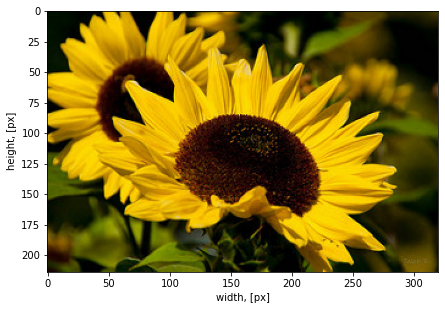

In [ ]:
# Displaying the image
fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.imshow(image_tmp)
ax.set_xlabel('width, [px]')
ax.set_ylabel('height, [px]')
plt.show()

In [ ]:
# Now we got to check if all the images have the same size
# In order to do so, let's create a numpy array with all the shapes stored
imgs_shapes = []
for img_path in sunflowers:
  # Reading the image
  img = load_image(img_path)
  # Storing the shape
  imgs_shapes.append(np.array(img.shape))
# Converting the list to a numpy array
imgs_shapes = np.array(imgs_shapes)
# Printing the shapes
print(imgs_shapes.shape)

(699, 3)


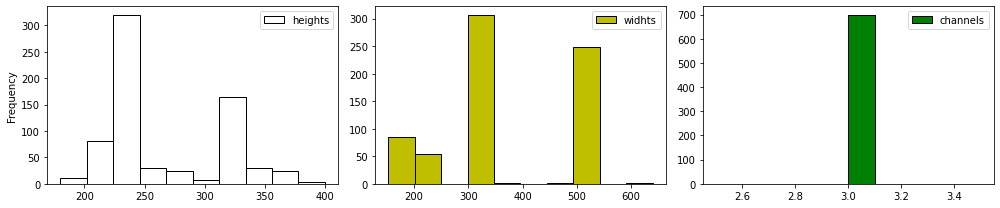

In [ ]:
# Displaying three histograms. The first corresponds to heights,
# the second corresponds to widths 
# and the latter corresponds to channels
fig,ax = plt.subplots(1,3,figsize=(14,3))

ax[0].hist(imgs_shapes[:,0],color='w',ec='k',label='heights')
ax[1].hist(imgs_shapes[:,1],color='y',ec='k',label='widhts')
ax[2].hist(imgs_shapes[:,2],color='g',ec='k',label='channels')
# Applying legends
ax[0].legend()
ax[1].legend()
ax[2].legend()
# Applying ylabel
ax[0].set_ylabel('Frequency')
# Getting a tight layout
fig.tight_layout()
plt.show()

We conclude the images have unequal sizes. Therefore, for the data preparation, we have to develop a function to normalize the image's size for each flower category.

### - Normalizing images

In [ ]:
def normalize_size(
    img : np.array,
    img_path : str,
    size : tuple = (200,200)
    ) -> None:
    """Function to normalize the image size."""
    try:
      # Convert from array to Image PIL object
      img_pil = Image.fromarray(img.astype(np.uint8))
      # Generate the thumbnail
      img_pil = img_pil.resize(size)
      # Saving the image
      img_pil.save(img_path, "JPEG")
    except IOError:
        print(f"Cannot create thumbnail for '{img_path}'")

# Running the function for each image
for img_path in sunflowers:
  # Reading the image
  img = load_image(img_path)
  # Reshaping the image
  normalize_size(img,img_path)

In [ ]:
# Checking the shape of one image
image_tmp = load_image(sunflowers[3])
# The 'shape' attribute returns the height, width and channel 
# dimensions, respectivelly
print(f'Image shape: {image_tmp.shape}')

Image shape: (200, 200, 3)


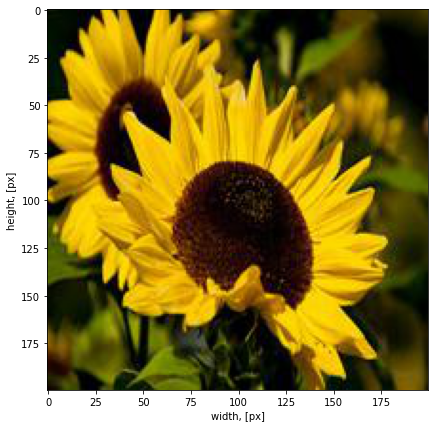

In [ ]:
# Displaying the image
fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.imshow(image_tmp)
ax.set_xlabel('width, [px]')
ax.set_ylabel('height, [px]')
plt.show()

### - Exploring the image distribution

In [ ]:
# Getting all the sunflower images to a list variable
sunflowers = list(data_dir.glob('sunflowers/*'))
print(len(sunflowers))

# Loading some image again
sunflower_tmp = load_image(sunflowers[3])
# The 'shape' attribute returns the height, width and channel 
# dimensions, respectivelly
print(f'Image shape: {sunflower_tmp.shape}')

699
Image shape: (200, 200, 3)


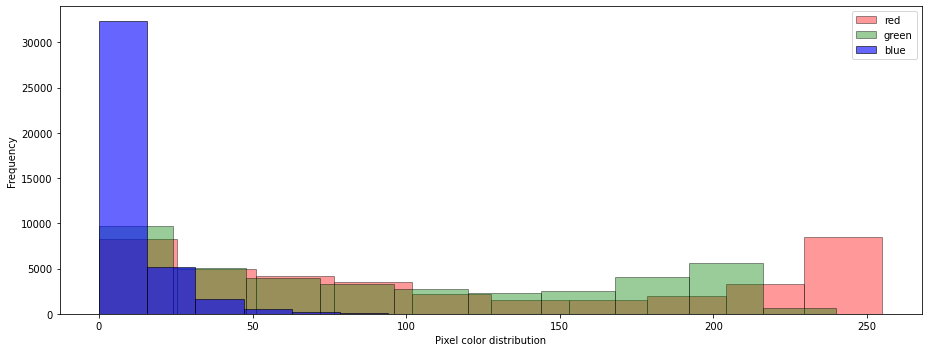

In [ ]:
# Displaying three color space pixel histograms. The first corresponds to red,
# the second corresponds to green and the latter corresponds to blue channels
fig,ax = plt.subplots(1,1,figsize=(13,5))

ax.hist(sunflower_tmp[:,:,0].flatten(),color='r',alpha=0.4,ec='k',label='red')
ax.hist(sunflower_tmp[:,:,1].flatten(),color='g',alpha=0.4,ec='k',label='green')
ax.hist(sunflower_tmp[:,:,2].flatten(),color='b',alpha=0.6,ec='k',label='blue')
# Applying legends
ax.legend()
# Applying ylabel
ax.set_ylabel('Frequency')
ax.set_xlabel('Pixel color distribution')
# Getting a tight layout
fig.tight_layout()
plt.show()

In [ ]:
# Getting all the sunflower images to a list variable
roses = list(data_dir.glob('roses/*'))
print(len(roses))

# Loading some image again
rose_tmp = load_image(roses[30])
# The 'shape' attribute returns the height, width and channel 
# dimensions, respectivelly
print(f'Image shape: {rose_tmp.shape}')

641
Image shape: (240, 179, 3)


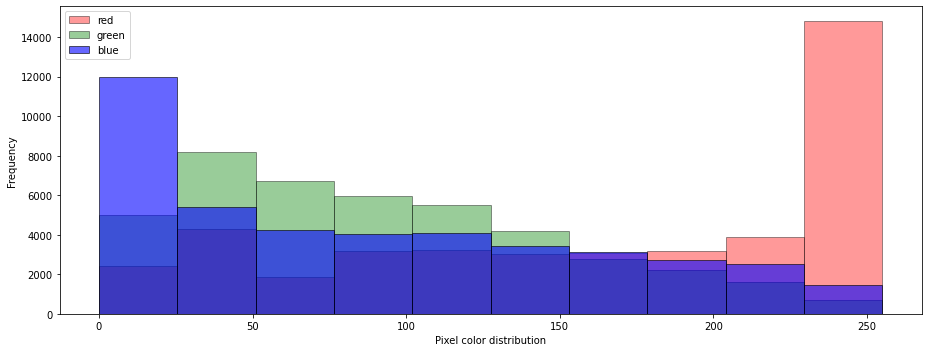

In [ ]:
# Displaying three color space pixel histograms. The first corresponds to red,
# the second corresponds to green and the latter corresponds to blue channels
fig,ax = plt.subplots(1,1,figsize=(13,5))

ax.hist(rose_tmp[:,:,0].flatten(),color='r',alpha=0.4,ec='k',label='red')
ax.hist(rose_tmp[:,:,1].flatten(),color='g',alpha=0.4,ec='k',label='green')
ax.hist(rose_tmp[:,:,2].flatten(),color='b',alpha=0.6,ec='k',label='blue')
# Applying legends
ax.legend()
# Applying ylabel
ax.set_ylabel('Frequency')
ax.set_xlabel('Pixel color distribution')
# Getting a tight layout
fig.tight_layout()
plt.show()

It looks like the red is more intense in the pictures containing roses. Therefore, we should investigate if this behavior is present throught all the roses dataset.

### - Exploring statistical metrics

In [ ]:
# Let's create a numpy array with the median values for each 
# pixel intensity distribution within the RGB color space
roses_mean = []
for img_path in roses:
  # Reading the image
  img = load_image(img_path)
  # Storing the median
  roses_mean.append([np.median(img[:,:,0]),
                     np.median(img[:,:,1]),
                     np.median(img[:,:,2]),
                     ])
# Converting the list to a numpy array
roses_mean = np.array(roses_mean)
# Printing the shapes
print(roses_mean.shape)

(641, 3)


In [ ]:
# Now, we do the same with the sunflowers
sunflowers_mean = []
for img_path in sunflowers:
  # Reading the image
  img = load_image(img_path)
  # Storing the median
  sunflowers_mean.append([np.mean(img[:,:,0]),
                          np.mean(img[:,:,1]),
                          np.mean(img[:,:,2]),
                          ])
# Converting the list to a numpy array
sunflowers_mean = np.array(sunflowers_mean)
# Printing the shapes
print(sunflowers_mean.shape)

(699, 3)


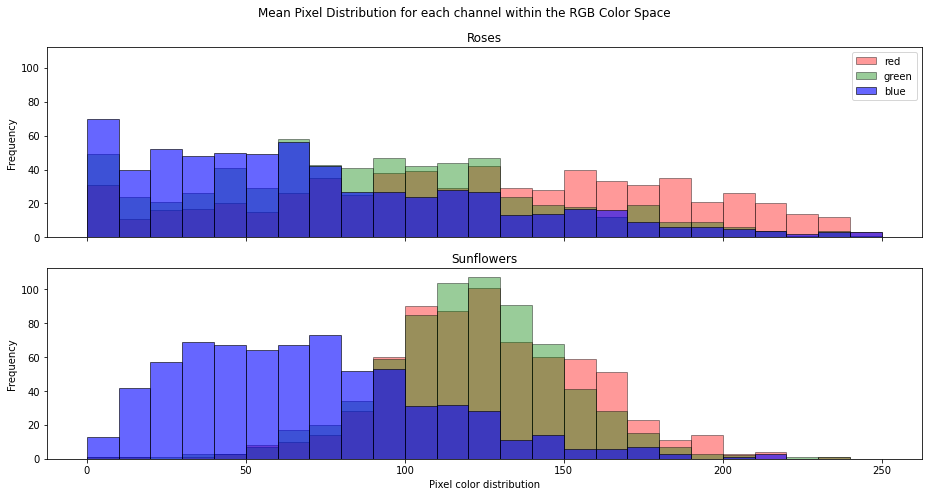

In [ ]:
# Let's visualize the results
fig,ax = plt.subplots(2,1,figsize=(13,7),sharex=True,sharey=True)

ax[0].hist(roses_mean[:,0].flatten(),bins=np.arange(0,256,10),color='r',alpha=0.4,ec='k',label='red')
ax[0].hist(roses_mean[:,1].flatten(),bins=np.arange(0,256,10),color='g',alpha=0.4,ec='k',label='green')
ax[0].hist(roses_mean[:,2].flatten(),bins=np.arange(0,256,10),color='b',alpha=0.6,ec='k',label='blue')
ax[1].hist(sunflowers_mean[:,0].flatten(),bins=np.arange(0,256,10),color='r',alpha=0.4,ec='k',label='red')
ax[1].hist(sunflowers_mean[:,1].flatten(),bins=np.arange(0,256,10),color='g',alpha=0.4,ec='k',label='green')
ax[1].hist(sunflowers_mean[:,2].flatten(),bins=np.arange(0,256,10),color='b',alpha=0.6,ec='k',label='blue')
# Applying legends
ax[0].legend()
# Applying ylabel
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Pixel color distribution')
# Applying titles
ax[0].set_title('Roses')
ax[1].set_title('Sunflowers')
fig.suptitle('Mean Pixel Distribution for each channel within the RGB Color Space')
# Getting a tight layout
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

One can depict from the figure above that sunflowers have less overlap between blue, green and red channels for pixel intensity values bellow 75. Therefore, the median of the pixel intensity is a great feature candidate to compose the modeling dataset. 

Another conclusion that one can make is regarding the greater red intensity present on roses when compared to sunflowers.

Now, we have to check some other statistics in order to evaluate possible features to compose our modeling dataset.

In [ ]:
# Let's create a numpy array with the standard deviation values for each 
# pixel intensity distribution within the RGB color space
roses_std = []
for img_path in roses:
  # Reading the image
  img = load_image(img_path)
  # Storing the std
  roses_std.append([np.std(img[:,:,0]),
                    np.std(img[:,:,1]),
                    np.std(img[:,:,2]),
                    ])
# Converting the list to a numpy array
roses_std = np.array(roses_std)
# Printing the shapes
print(roses_std.shape)

(641, 3)


In [ ]:
# Now, we do the same with the sunflowers
sunflowers_std = []
for img_path in sunflowers:
  # Reading the image
  img = load_image(img_path)
  # Storing the median
  sunflowers_std.append([np.std(img[:,:,0]),
                         np.std(img[:,:,1]),
                         np.std(img[:,:,2]),
                         ])
# Converting the list to a numpy array
sunflowers_std = np.array(sunflowers_std)
# Printing the shapes
print(sunflowers_std.shape)

(699, 3)


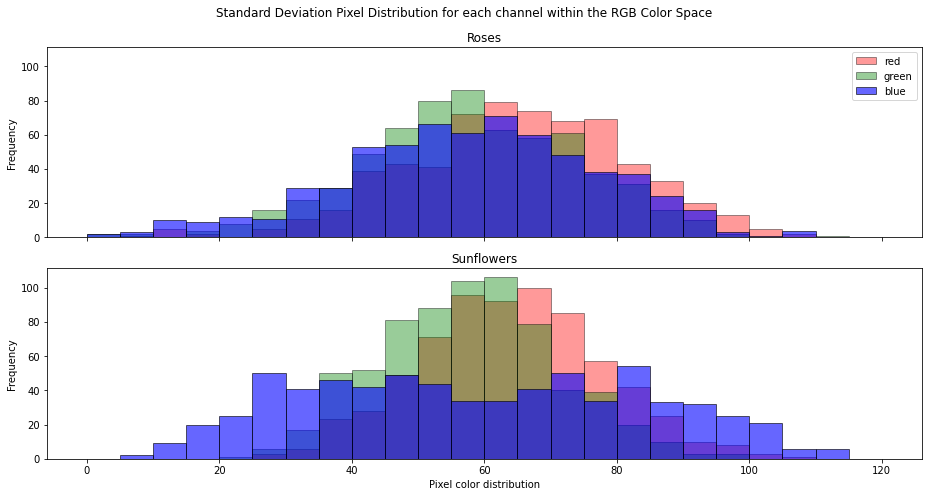

In [ ]:
# Let's visualize the results
fig,ax = plt.subplots(2,1,figsize=(13,7),sharex=True,sharey=True)

ax[0].hist(roses_std[:,0].flatten(),bins=np.arange(0,125,5),color='r',alpha=0.4,ec='k',label='red')
ax[0].hist(roses_std[:,1].flatten(),bins=np.arange(0,125,5),color='g',alpha=0.4,ec='k',label='green')
ax[0].hist(roses_std[:,2].flatten(),bins=np.arange(0,125,5),color='b',alpha=0.6,ec='k',label='blue')
ax[1].hist(sunflowers_std[:,0].flatten(),bins=np.arange(0,125,5),color='r',alpha=0.4,ec='k',label='red')
ax[1].hist(sunflowers_std[:,1].flatten(),bins=np.arange(0,125,5),color='g',alpha=0.4,ec='k',label='green')
ax[1].hist(sunflowers_std[:,2].flatten(),bins=np.arange(0,125,5),color='b',alpha=0.6,ec='k',label='blue')
# Applying legends
ax[0].legend()
# Applying ylabel
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Pixel color distribution')
# Applying titles
ax[0].set_title('Roses')
ax[1].set_title('Sunflowers')
fig.suptitle('Standard Deviation Pixel Distribution for each channel within the RGB Color Space')
# Getting a tight layout
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

Observing the figure above, it is possible to infer that there is a slightly difference between the roses and sunflowers STD images distributions. The latter has a blue channel SDT images distribution with uniform-ish shape. Therefore, the STD of the pixel intensity can also be great feature candidate to compose the modeling dataset. 

For now, we already have enough features to compose our data preparation dataset. Let's dive into that.

# 3. Data Preparation



### - Extracting features from images

In [ ]:
def extract_features(
    image : np.array,
    ) -> list:
    """
    This function extracts some statistics from the image and transforms it into
    features that will be used for modeling. This function returns a list of 
    float numbers.
    """
	  # Splitting up the image color space channels into separate variables
    (R, G, B) = image[:, :, 0], image[:, :, 1], image[:, :, 2] 
    # Extraindo as features para cada canal
    features = [
    np.mean(R), 
    np.mean(G), 
    np.mean(B), 
    np.std(R), 
    np.std(G),
    np.std(B),
    ]
    # Returning the feature list
    return features

### - Data preparation pipeline

In [ ]:
def data_preparation_pipeline(
    data_dir : pathlib.PosixPath, 
    categories : list = ['roses','sunflowers'],
) -> pd.DataFrame:
    """
    Realiza a preparação dos dados retornando um `pd.DataFrame` com o conjunto
    de dados composto pelas variáveis e alvos.
    """
    # Creating lists to store the images and labels, respectivelly
    data = []
    # Storing image paths for each category that was parsed
    for cat in categories:
        img_paths_cat = list(data_dir.glob(f'{cat}/*'))
        # Reading the image throught provided path
        for path in img_paths_cat:
            img_cat = load_image(path)
            # Extract features
            feature_cat = extract_features(img_cat)
            # Storing variables
            data.append(feature_cat+[img_cat]+[cat])
    
    # Converting array to pandas
    columns = ['Rm','Gm','Bm','Rs','Gs','Bs','image','target']    
    return pd.DataFrame(data, columns=columns)

# Running the data preparation pipeline function
data = data_preparation_pipeline(data_dir, categories=['roses', 'sunflowers'])

In [ ]:
data.head()

,Rm,Gm,Bm,Rs,Gs,Bs,image,target
0,160.908174,83.049718,123.453051,80.235174,54.881499,59.481472,"[[[3, 9, 25], [3, 9, 25], [3, 8, 27], [3, 8, 2...",roses
1,97.939258,56.316536,56.650651,55.670756,40.162362,41.093774,"[[[152, 119, 104], [167, 128, 131], [168, 129,...",roses
2,127.807900,114.949756,59.623175,69.321059,60.909479,40.749831,"[[[63, 66, 55], [52, 55, 36], [59, 62, 35], [7...",roses
3,93.863940,64.826216,62.835363,70.996279,47.881742,53.598333,"[[[147, 69, 83], [139, 61, 75], [136, 58, 72],...",roses
4,160.383074,50.349492,57.976831,59.135922,54.844427,37.049242,"[[[201, 127, 38], [201, 128, 34], [206, 124, 4...",roses


Here is the pandas dataframe containing all the features necessary for our modeling.

### - Exploring category balance


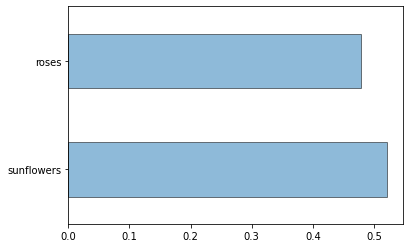

In [ ]:
# We have to check the classes balance
data['target'].value_counts(normalize=True).plot.barh(alpha=0.5,ec='k')
plt.show()

Then, we conclude that the dataset is pretty much balanced and there is no need to explore oversampling or undersampling techniques.

### - Exploring Correlation

Lastly, we are going to run a correlation test.

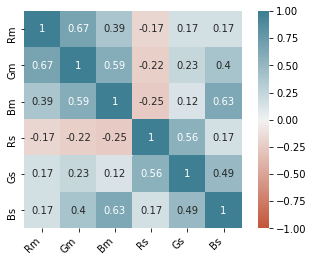

In [ ]:
corr = data.drop(labels=['target','image'],axis=1).corr()

# Plotting the heatmap
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
)
# Fixing the x labels
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

The strongest correlation caught by our eyes is between `Gm` and `Rm` (about 0.67). Even though we consider it a correlation (above 0.6), it is not supposed to be a big trouble for this example. Therefore, we are going to keep all the features in the dataset.

# 3. Modeling

### - Splitting the dataset

In [ ]:
def split_dataset(
    df: pd.DataFrame,
    val_ratio : float = 0.3,
    shuffle : bool = True,
    target='target',
    random_state=42
) -> [np.array,np.array,np.array,np.array]:
    """
    Split the data, creating two datasets: play and validation by wrapping the 
    sklearn method `train_test_split`
    """
    # Calling the sklearn method `train_test_split`
    X_play, X_val, y_play, y_val = train_test_split(
        df, df[target],
        stratify=df[target],
        test_size=val_ratio,
        shuffle=shuffle,
        random_state=random_state
        )
    # Removing the target
    X_play = X_play.drop(labels=[target,'image'],axis=1)
    X_val = X_val.drop(labels=[target,'image'],axis=1)
    y_play = y_play
    y_val = y_val

    return X_play, X_val, y_play, y_val

# Running the function to separate our dataset
X_play, X_val, y_play, y_val = split_dataset(data)

print(f"X's shapes: {X_play.shape}, {X_val.shape}")
print(f"y's shapes: {y_play.shape}, {y_val.shape}")

X's shapes: (938, 4), (402, 4)
y's shapes: (938,), (402,)


In [ ]:
def modeling(
    X_play : np.array,
    X_val : np.array,
    y_play : np.array,
    y_val : np.array,
    model = None,
    n_folds : int = 10,
) -> dict:
    """
    Executa a modelagem, treinando o modelo e retornando métricas para se
    acompanhar a performance
    """
    # Checking if there is a model provided by the user
    if model == None:
        raise Exception("You need to provide a model")
        
    # Defining the cross-validation strategy
    cv = StratifiedKFold(n_folds)

    # Determining the score of the modeling
    list_metrics = cross_val_score(
        model, 
        X_play, 
        y_play, 
        cv=cv,
        scoring='accuracy'
        )
    avg_accuracy_cv = np.mean(list_metrics) # Mean
    std_accuracy_cv = np.std(list_metrics)  # STD

    # Fitting the model with the play dataset
    model.fit(X_play, y_play)
    # Getting the accuracy from the validation dataset
    accuracy_test = accuracy_score(y_val, model.predict(X_val))
    dict_metrics = {
        'CV Accuracy (mean)' : np.round(avg_accuracy_cv,3),
        'CV Accuracy (std)' : np.round(std_accuracy_cv,3),
        'Validation Accuracy' : np.round(accuracy_test,3)
    }
    return dict_metrics

# Defining the model
model = SVC()
# Running the modeling 
results = modeling(X_play, X_val, y_play, y_val, model=model, n_folds=10)
print(results)

{'CV Accuracy (mean)': 0.823, 'CV Accuracy (std)': 0.041, 'Validation Accuracy': 0.863}


Let's try some different models in order to check which one is best.

In [ ]:
%%time 

# Defining a dictionary to store all the models we are going to test
models = {
    'SVC' : SVC(),
    'LogisticRegression' : LogisticRegression(class_weight='balanced'),
    'KNeighborsClassifier' : KNeighborsClassifier(),
    'GaussianNB' : GaussianNB(),
    'DecisionTreeClassifier' : DecisionTreeClassifier(),
    'RandomForestClassifier' : RandomForestClassifier(),
}
# Creating a dictionary to store the results
results = dict()
# Iterating for each model in the models dictionary
for name,model in models.items():
  # Running the modeling function to get the results
  model_result = modeling(X_play, X_val, y_play, y_val, model, n_folds=10)
  # Storing the results into the results dictionary
  results[name] = model_result

CPU times: user 3.25 s, sys: 18.9 ms, total: 3.26 s
Wall time: 3.26 s


In [ ]:
# Displaying the results
pd.DataFrame(results).T

,CV Accuracy (mean),CV Accuracy (std),Validation Accuracy
SVC,0.823,0.041,0.863
LogisticRegression,0.806,0.037,0.838
KNeighborsClassifier,0.799,0.030,0.818
GaussianNB,0.737,0.061,0.716
DecisionTreeClassifier,0.749,0.017,0.726
RandomForestClassifier,0.792,0.044,0.816


In [ ]:
# Fitting the best model with our play data
model = models['SVC'].fit(X_play,y_play)

In [ ]:
# Getting the index of an image from the validation dataset
testing_index = 15

# Predicting the output
prediction = model.predict([X_val.iloc[testing_index]])
print(f"The prediction was: '{prediction}'")

# Locating the true results from the dataset
idx = X_val.iloc[testing_index].name
category = y_val.iloc[testing_index]
print(f"True category is: '{category}'")
print(f"Index is: '{idx}'")

The prediction was: '['sunflowers']'
True category is: 'sunflowers'
Index is: '975'


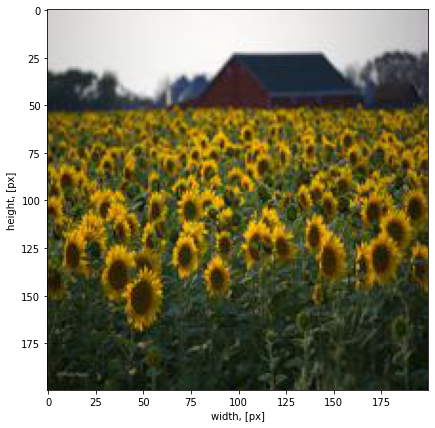

In [ ]:
# Selecting the image
image_tmp = data.loc[idx,'image']

# Displaying the image
fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.imshow(image_tmp)
ax.set_xlabel('width, [px]')
ax.set_ylabel('height, [px]')
plt.show()